## Determining the Square Footage and Lot Square Footage of Unsafe Properties

This notebook pulls square footage data using Zillow's API (requires API key!!!) and merges this data into an existing list of properties. For properties without square footage data, we estimate the square footage using the estimated price of the house ("Zestimate"). 

We run a regression of square footage as the dependent variable and the Zestimate as the independent variable for the 100 or so houses for which we have both data points. We then use this model's coefficients to predict the square footage for the houses for which we only have the Zestimate data. For houses for which we don't have Zestimate or square footage data (about 30 houses of the 437), we use the median value (since the square footages are not normally distributed) of the rest of the values to estimate their square footage.

### Imports

In [1]:
import pandas as pd
import urllib
import requests
import json
import matplotlib.pyplot as plt

#pull in dataset of Zillow codes of properties (needed to make API calls)
zpid_codes_df = pd.read_csv('zpid_codes.csv')
#convert into list
codes = zpid_codes_df['zpid'].tolist()

### Scraping the Square Footage Data from Zillow

This code loops through each property code and pulls the available data form the Zillow API. If the API doesn't return data (error code 502 or 501), the square footage isn't available. Set these values to "NaN." We could parse the XML, but there are only two data points we really need, so we can just use the 'find' function to save time.

In [2]:
#initializing lists
data_list = []
sqfts = []
lt_sqfts = []

count = 1

#for each property code
for id in codes:
    
    print(count)
    
    #url = 'http://www.zillow.com/webservice/GetUpdatedPropertyDetails.htm?zws-id=X1-ZWz181zla65b0r_35s1w&zpid=10481096'
    url = 'http://www.zillow.com/webservice/GetUpdatedPropertyDetails.htm?zws-id=X1-ZWz181zla65b0r_35s1w&zpid='+str(id)
    data = urllib.request.urlopen(url)
    
    data = data.read()
    
    data = data.decode('utf-8')
    
    if data[data.find('code')+5:data.find('</code')] == '502' or data[data.find('code')+5:data.find('</code')] == '501':
        sqft = 'NaN'
        lt_sqft = 'NaN'
        
    else:
        #square footage and lot square footage data
        sqft = data[data.find('finishedSqFt') + len('finishedSqFt') + 1: data.find('</finishedSqFt')]
        lt_sqft = data[data.find('lotSizeSqFt') + len('lotSizeSqFt') + 1:data.find('</lotSizeSqFt')]
    
    sqfts.append(sqft)
    lt_sqfts.append(lt_sqft)
    
    count = count + 1

    #data_list.append(data.read())
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


### Cleaning the Square Footage Data

In [3]:
#clean up this square footage data and put into DataFrame
square_footage_df = pd.DataFrame(sqfts, columns=['Square Footage'])
square_footage_df['Lot Square Footage'] = lt_sqfts
square_footage_df['Square Footage'].iloc[29] = 'NaN'
square_footage_df['Lot Square Footage'].iloc[29] = 'NaN'
square_footage_df['ZPID'] = codes
square_footage_df = square_footage_df.apply(pd.to_numeric, errors = 'coerce' )
#some houses are listed more than once (probably because they originally had different inspection dates). Drop them.
square_footage_df.drop_duplicates(subset='ZPID', keep='first', inplace=True)

#pull in Zillow property data we previously downloaded (has Zestimate data values)
property_data_df = pd.read_csv('zillow_property_data.csv')
property_data_df.drop(property_data_df.columns[15:],axis=1,inplace=True)
property_data_df.drop(property_data_df.columns[8:14],axis=1,inplace=True)
property_data_df.drop_duplicates(subset='ZPID', keep='first', inplace=True)

#merge the two datasets together
complete_data = pd.merge(property_data_df,square_footage_df,how='left',left_on='ZPID',right_on='ZPID')

You can see there is a positive relationship between Zillow Estimate of Property and the square footage:

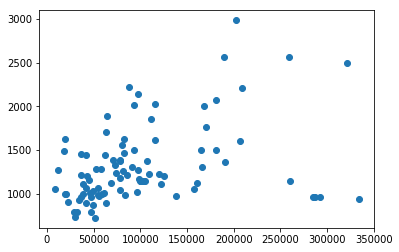

In [4]:
plt.scatter(complete_data['Z-Estimate'], complete_data['Square Footage'])

In [5]:
#run the regressions to estimate square footages and lot square footages of the properties with just Zestimate data
import statsmodels.api as sm

X = complete_data[['Z-Estimate','Square Footage']].dropna()['Z-Estimate']
Y = complete_data[['Z-Estimate','Square Footage']].dropna()['Square Footage']
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()

Xnew = sm.add_constant(complete_data['Z-Estimate'])

complete_data['Estimated Square Footage'] = model.predict(Xnew)

X2 = complete_data[['Z-Estimate','Lot Square Footage']].dropna()['Z-Estimate']
Y2 = complete_data[['Z-Estimate','Lot Square Footage']].dropna()['Lot Square Footage']
X2 = sm.add_constant(X2) # adding a constant

model2 = sm.OLS(Y2, X2).fit()

X2new = sm.add_constant(complete_data['Z-Estimate'])

complete_data['Estimated Lot Square Footage'] = model2.predict(X2new)

In [6]:
#fill in the missing square footage data points with the estimated data points
complete_data['Final Square Footage'] = complete_data['Square Footage']
complete_data['Final Lot Square Footage'] = complete_data['Lot Square Footage']
complete_data['Final Square Footage'] = complete_data['Final Square Footage'].fillna(complete_data['Estimated Square Footage'])
complete_data['Final Lot Square Footage'] = complete_data['Final Lot Square Footage'].fillna(complete_data['Estimated Lot Square Footage'])

At this point, we have about 93% of the properties here with square footage data. However, remember there are only 411 unique ZPID's here. There are still 30 or so other properties that don't have ZPID's for which we need to calculate square footage. Bring in these properties, merge them into this data set, and then use fillna() with means in order to give them (and the missing ones below) a square footage value.

In [7]:
complete_data.head(3)

,Search Id,Street,City,State,Zip,Response Code,Response Text,ZPID,Z-Estimate,Square Footage,Lot Square Footage,Estimated Square Footage,Estimated Lot Square Footage,Final Square Footage,Final Lot Square Footage
0,1,828 BROOKLYN ST,Philadelphia,PA,19104-1444,0,Request successfully processed,10201687,42239.0,NaN,NaN,1179.043947,913.222245,1179.043947,913.222245
1,2,5537 BROOMALL ST,Philadelphia,PA,19143-4008,0,Request successfully processed,10481096,67754.0,NaN,NaN,1239.290829,1060.465671,1239.290829,1060.465671
2,3,4429 BROWN ST,Philadelphia,PA,19104-1356,0,Request successfully processed,10200497,41339.0,NaN,NaN,1176.918837,908.028473,1176.918837,908.028473


### Merging the Square Footage Data into the Existing Dataset of Properties

In [10]:
#reading in a previously prepared data set (with more details) of the same properties
unsafe_trimmed_df = pd.read_csv('unsafe_trimmed_2017.csv')

#get rid of duplicates in this dataset (440 "properties" listed, but there are really just 437)
unsafe_trimmed_df.drop_duplicates(subset='address', keep='first', inplace=True)

#clean up the final dataset of unsafe properties (now with the square footage data) before we write the file to CSV
unsafe_trimmed_df.drop('Unnamed: 0',axis=1,inplace=True)
unsafe_trimmed_final = pd.merge(unsafe_trimmed_df,complete_data[['Street','Final Square Footage','Final Lot Square Footage']],how='left',left_on='address',right_on='Street')
unsafe_trimmed_final.drop('Street',axis=1,inplace=True)
unsafe_trimmed_final['Final Square Footage'] = unsafe_trimmed_final['Final Square Footage'].fillna(unsafe_trimmed_final['Final Square Footage'].median())
unsafe_trimmed_final['Final Lot Square Footage'] = unsafe_trimmed_final['Final Lot Square Footage'].fillna(unsafe_trimmed_final['Final Lot Square Footage'].median())

### Final Merged Dataset

In [11]:
unsafe_trimmed_final.head()

,the_geom,lng,objectid,addresskey,opa_account_num,address,unit,zip,censustract,ownername,...,casegrp,violationtype,violationdescription,mostrecentinsp,geocode_x,geocode_y,lat,caseaddeddate,Final Square Footage,Final Lot Square Footage
0,0101000020E6100000FAD672EB61CD52C0A4E6CAE9F3FB...,-75.209102,61,52522,62301900.0,828 BROOKLYN ST,NaN,19104-1444,107,MONFISTON LINA,...,CSU,PM15-108.1,UNSAFE STRUCTURE,2017-05-31 07:05:00,2.680592e+06,241584.187740,39.968381,2017-06-01 12:03:04,1179.043947,913.222245
1,0101000020E6100000B5FC4D70DECE52C04988B5D7DFF8...,-75.232327,62,52767,513105200.0,5537 BROOMALL ST,NaN,19143-4008,72,PETER ARROYO RUTH,...,CSU,PM15-108.1,UNSAFE STRUCTURE,2017-03-27 14:38:00,2.674335e+06,232640.342957,39.944331,2017-03-27 14:33:18,1239.290829,1060.465671
2,0101000020E6100000F942775A94CD52C03C56165AC3FB...,-75.212180,67,54043,62008900.0,4429 BROWN ST,NaN,19104-1356,105,CAMPBELL WANDA V TR,...,CSU,PM15-108.1,UNSAFE STRUCTURE,2017-03-27 08:08:00,2.679745e+06,241019.747447,39.966899,2015-11-24 08:51:33,1176.918837,908.028473
3,0101000020E61000001FA5570882CF52C039AF2415F0FB...,-75.242312,83,60033,341044300.0,6120 CALLOWHILL ST,NaN,19151-4318,96,QUEZADA ANGEL,...,CSU,PM15-108.1,UNSAFE STRUCTURE,2017-11-14 09:10:00,2.671289e+06,241275.582446,39.968264,2017-11-15 09:06:46,2025.000000,1109.000000
4,0101000020E6100000D62ED17610C952C01EBCC7462B05...,-75.141630,90,61478,493181700.0,5734 N CAMAC ST,NaN,19141-4108,276,NATHANIEL HUMAN 1/2INT SHAW WALLS,...,CSU,PM15-108.1,UNSAFE STRUCTURE,2017-08-03 10:08:00,2.698721e+06,268353.120304,40.040383,2017-08-03 10:10:24,1153.991256,851.993448


In [309]:
#Write the file to CSV. Done.
unsafe_trimmed_final.to_csv('unsafe_trimmed_2017_w_sqft.csv')